In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import os
import pickle
sys.path.append(os.path.abspath(os.path.join("../")))
sys.path.append(os.path.abspath(os.path.join("../", "lib", "pysgmcmc/")))

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

# Training model
from models.continual_training_dyn import TrainingDynamics

/home/thobotics/anaconda2/envs/tf14/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Generate data 

In [3]:
def f(x):
    return 3*(1.0*np.sin(0.25*np.pi*x) + 0.15*np.sin(0.75*np.pi*x) + 0.25*np.sin(1.25*np.pi*x))

def generate_data(sample_size=2000, low=-2*math.pi, high=-math.pi, seed=42):
    def sinus_model(x):
        return np.sin(1.5*x + np.pi/8.)

    rng = np.random.seed(seed)
    
    x = np.random.uniform(low=low, high=high, size=(sample_size,))
    y = f(x) + np.random.normal(0, 0.0225*np.abs(sinus_model(x)), sample_size)
    
    return x, y

def generate_original_data(sample_size = 2000, seed=42):
    def sinus_model(x):
        return np.sin(1.5*x + np.pi/8.)

    rng = np.random.seed(seed)
    
    x = np.random.uniform(low=0., high=0.5, size=(sample_size))
    y = f(x) + np.random.normal(0, 0.0225*np.abs(sinus_model(x)), sample_size)
    
    return x, y

In [4]:
# Generate data
x_train, y_train = generate_original_data(50)

x_validate = np.arange(0., 8., 0.01)
y_validate = f(x_validate)

# Convert to matrix
x_train = x_train[:, np.newaxis]
y_train = y_train[:, np.newaxis]

x_validate = x_validate[:, np.newaxis]
y_validate = y_validate[:, np.newaxis]

In [5]:
def plot_model(x_tr=None, y_tr=None):
    
    # Setup state for plotting
    plt.rcParams['figure.figsize'] = (10, 5)               
    fig = plt.figure()
    
    plt.plot(x_validate, y_validate, 'r', label = '$m$')
    plt.scatter(x_train, y_train, color = 'blue', s = 15.5)
    
    if x_tr is not None:
        plt.scatter(x_tr, y_tr, color = 'k', s = 1.5)
    
    plt.xlim([-0., 8.])
    plt.ylim([-3.5, 3.5])

    plt.grid()
    plt.show()

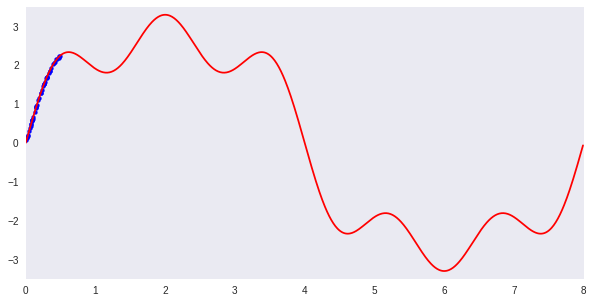

In [6]:
plot_model()

## Training 

In [7]:
import logging
logger = logging.getLogger()
# logger.setLevel(logging.INFO)
# logger.setLevel(logging.DEBUG)

tf.reset_default_graph()

# Create model
n_timestep = 1
n_inputs  = 1
n_outputs = 1

training = TrainingDynamics(n_inputs, n_outputs, n_timestep, action_bounds=([-1., -1.57], [1., 1.57]),
                          model_type="ME", n_nets=15, n_units=500, scale=5.5,
                          activation=tf.tanh, batch_size=20, a0=1.0, b0=0.1, a1=1.0, b1=1.0)

In [8]:
# Add data
u_train = np.array([]).reshape(x_train.shape[0], 0)
training.add_data(x_train, u_train, y_train)

In [9]:
training.run_normal(x_validate, y_validate, step_size=1.0e-3, max_iters=500)

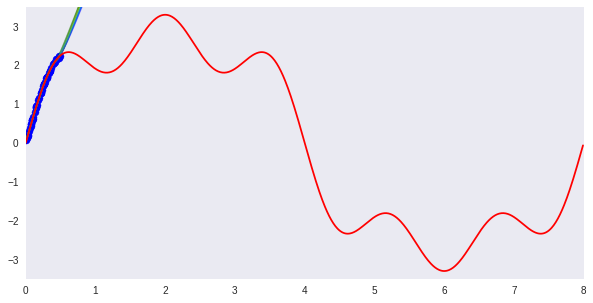

In [10]:
def plot_bnn_model(x_new=None, y_new=None):
    
    # Setup state for plotting
    plt.rcParams['figure.figsize'] = (10, 5)               
    fig = plt.figure()

    color = ['green', 'k', 'yellow', 'cyan', "blue"]
    
    for i in range(training.model.n_nets):
        y_pred, _ = training.predict(x_validate, return_individual_predictions=True, model_idx=i)
        plt.plot(x_validate, y_pred, color[i % 5], alpha=0.35)
        
    plt.plot(x_validate, y_validate, 'r', label = '$m$')
    plt.scatter(training.xu, training.y, color='blue', s=50.5)
    
    if x_new is not None:
        plt.scatter(x_new, y_new, color='black', s=50.5)
    
    # Plot last model
    # y_pred, _ = training.predict(x_validate, normal=True, return_individual_predictions=True, model_idx=training.model.n_nets-1)
    # plt.plot(x_validate, y_pred, "black", alpha=1.0, linewidth=3)
    
    plt.xlim([-0., 8.])
    plt.ylim([-3.5, 3.5])

    plt.grid()
    plt.show()
        
plot_bnn_model()

# Online Learning

Iter 0, 0



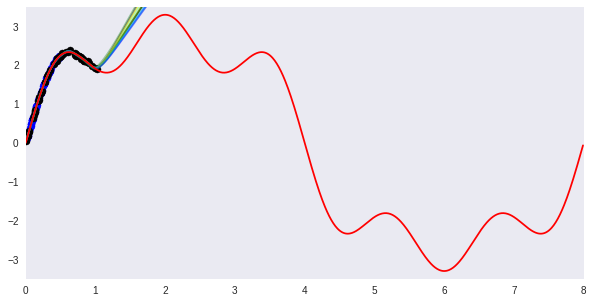

Iter 0, 1



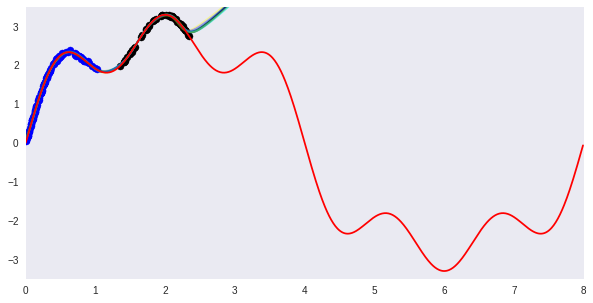

Iter 0, 2



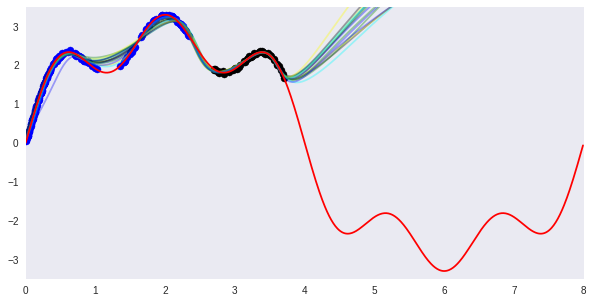

Iter 1, 0



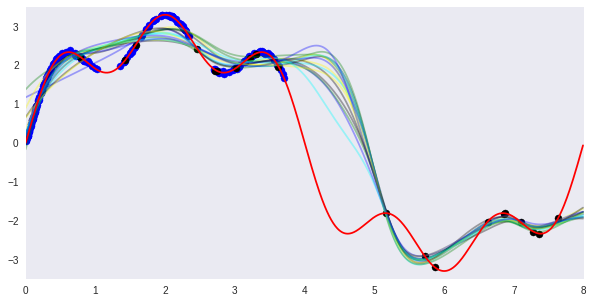

Iter 1, 1



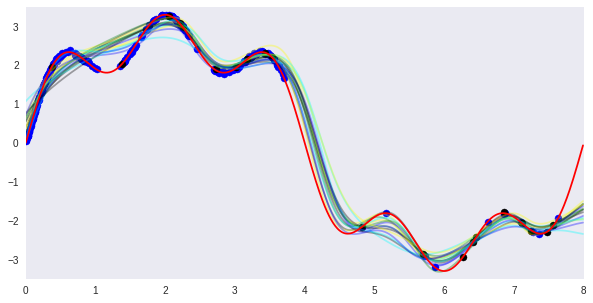

Iter 1, 2



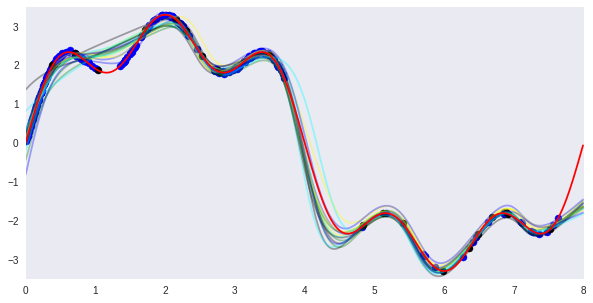

In [11]:
from IPython import display

switch_start = [0., 4.5, 8.5]
switch_end = [4.0, 8.0, 10.]
gap = 0.3

#sssidx = [0]*3 + [1]*2
idx = [0,1]
for i in range(2):
    
    start = switch_start[idx[i]]
    step = (switch_end[idx[i]] - start - gap*3) / 3.
    
    for j in range(3):
        print("Iter %d, %d\n" % (i, j))
        
        if i == 0:
            end = start + step
            x_new, y_new = generate_data(50, low=start, high=end, seed=22 + (i+j)*5)
            start = end + gap
        else:
            x_new_1, y_new_1 = generate_data(10, low=switch_start[idx[i-1]], high=switch_end[idx[i-1]] - gap, seed=22 + (i+j)*5)
            
            end = switch_end[idx[i]] - gap # start + step
            x_new_2, y_new_2 = generate_data(10, low=start, high=end, seed=22 + (i+j)*5)
            # start = end + gap
            
            x_new = np.hstack([x_new_1, x_new_2])
            y_new = np.hstack([y_new_1, y_new_2])
            
        x_new = x_new[:, np.newaxis]
        y_new = y_new[:, np.newaxis]
        u_new = np.array([]).reshape(x_new.shape[0], 0)

        #training.add_data(x_new, u_new, y_new)
        #training.run_normal(x_validate, y_validate, step_size=1.0e-3, max_iters=500)
        
        training._fit(x_new, u_new, y_new)
        training.run_normal(x_validate, y_validate, x_new, y_new, step_size=1.0e-3, max_iters=500)

        plot_bnn_model(x_new, y_new)
        
        training.add_data(x_new, u_new, y_new)

        display.display()

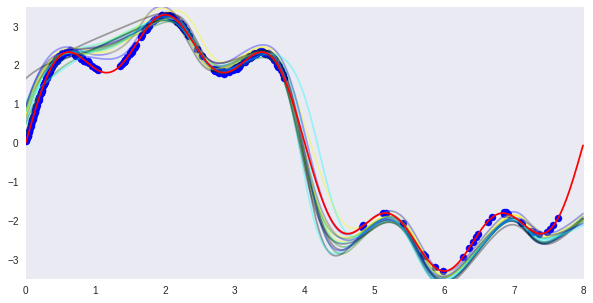

In [12]:
plot_bnn_model()